# Exploration of TMDB Movie Data
## Table of Contents
<ul>
<li><a href="#wrangling">Preliminary Wrangling</a></li>
<li><a href="#uni">Univariate Exploration</a></li>
<li><a href="#bi">Bivariate Exploration</a></li>
<li><a href="#multi">Multiariate Exploration</a></li>
</ul>

<a id='wrangling'></a>
## Preliminary Wrangling
<br>
The dataset contains information over 10,000 movies from 1960 to 2015.

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# set plot style
sns.set_style('darkgrid')
# use magic command to embed visualization in notebook
%matplotlib inline

In [2]:
# load dataset into a pandas dataframe
df = pd.read_csv('tmdb-movies.csv')

In [3]:
# get high-level overview of data shape and composition
print(df.shape)
print(df.info())
df.head(3)

(10866, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj   

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08


**Quality Issue 1**: extraneous columns <br>

`Reasoning`: <br>
- imdb_id is extraneous given id exists <br>
- budget_adj, revenue_adj are budget and revenue values adjusted for inflation. I favor them over budget and revenue when exploring trends over time <br> 
- cast, homepage, tageline, overview, production_companies won't be used in analyzing my features of interest <br>
- release_year is good enough, so I don't need release_year <br>

**Cleaning Quality Issue 1**: drop extraneous columns

In [4]:
# make a copy of the dataset
df_clean = df.copy()
# drop columns not used in my analysis
df_clean.drop(columns = ['imdb_id', 'budget', 'revenue', 'cast', 'homepage', 'tagline', 'overview',
                         'production_companies', 'release_date'], inplace = True)

**Quality Issue 2**: keywords, genres with multiple values separated by " | " <br>

**Cleaning Quality Issue 2**: no action

`Reasoning`: <br>
keywords, genres contain multiple values seperated by verticle bar in each cell. <br> But I won't do any change because each movie is usually with more than one genres and keywords for summary. <br> The table would be very huge if I split each of them into seperate rows.

**Quality Issue 3**: columns containing null values <br>

In [5]:
# get all columns containing null values
c_null = []
for c in df_clean.columns:
    if not df_clean[c].isnull().sum()==0:
        c_null.append(c)
print(len(c_null))
print(c_null)

3
['director', 'keywords', 'genres']


**Cleaning Quality Issue 3**: drop only column(s) with insignificant amount of null values

In [6]:
# check the number of null values
for c in c_null:
    sum_null = df_clean[c].isnull().sum()
    print(c, sum_null)

director 44
keywords 1493
genres 23


`Reasoning`: <br>
The totals of the null values in director and genres are insignificant. <br>
Dropping them won't impact data integrity.

In [7]:
# drop null from two columns
c_drop = ['director','genres']
df_clean.dropna(subset = c_drop, inplace = True)

`Reasoning`: <br>
keywords has a considerable amount of null values. <br> Dropping them has the side effect of losing valuable information on those records, and thus impact data integrity. <br> I decide to keep null values in keywords.

**Quality Issue 4**: id is integer not string

**Cleaning Quality Issue 4**: convert id from integer to string

In [8]:
# convert id datatype
df_clean.id = df_clean.id.astype(str)

**Quality Issue 5**: 1 duplicated record

In [9]:
# check duplicates
df_clean.duplicated().sum()

1

**Cleaning Quality Issue 5**: drop duplicated record

In [10]:
# dedupe
df_clean.drop_duplicates(inplace = True)

**Quality Issue 6**: small amount of missing values (0) in runtime; significant amount in budget_adj, revenue_adj

In [11]:
# get statistical summary of the dataset
df_clean.describe()

,popularity,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10800.000000,10800.000000,10800.000000,10800.000000,10800.000000,1.080000e+04,1.080000e+04
mean,0.649455,102.189722,218.600741,5.970880,2001.289537,1.765437e+07,5.167714e+07
std,1.002441,30.783873,577.165055,0.933006,12.819545,3.438403e+07,1.450182e+08
min,0.000188,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,0.209157,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,0.385471,99.000000,39.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,0.717508,111.250000,147.000000,6.600000,2011.000000,2.103337e+07,3.408743e+07
max,32.985763,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


In the statistical summary, I observe runtime, budget_adj, revenue_adj with values of 0. This is worth looking into. 

In [12]:
# get the counts of 0 values for the columns  
c_zero = ['runtime', 'budget_adj', 'revenue_adj']
for c in c_zero:
    count_zero = df_clean.groupby(c).count()['id'][0]
    print(c, count_zero)

runtime 28
budget_adj 5636
revenue_adj 5952


**Quality Issue 6**: 
- drop zero from runtime with small count of zero
- replace zero with null for columns budget_adj, revenue_adj with significant counts

In [13]:
# drop zero values of runtime column
df_clean = df_clean.query('runtime != 0')

`Reasoning`: <br>
budget_adj, revenue_adj both have significant amount of zero values. Dropping their zero values will impact data integrity. So instead, I replace 0 with Null using `np.NaN`.

In [14]:
# replace 0 with null in budget_adj, revenue_adj 
c_replace = ['budget_adj', 'revenue_adj']
[df_clean[c].replace(0, np.NaN, inplace = True) for c in c_replace]

[None, None]

To facilitate my analysis, I create a new column 'decades' that categorize each individual release_year.

In [15]:
# set bin edges that will be used to cut 'release_year' data into groups
bin_edges = [1960, 1970, 1980, 1990, 2000, 2010, 2020]
# set bin labels for the 6 decades
bin_labels = ['1960s','1970s', '1980s', '1990s', '2000s', '2010s']
# create a categorical variable 'decades'
df_clean['decades'] = pd.cut(df_clean.release_year, bin_edges, 
                                right = False, labels = bin_labels)

In [16]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10772 entries, 0 to 10865
Data columns (total 13 columns):
id                10772 non-null object
popularity        10772 non-null float64
original_title    10772 non-null object
director          10772 non-null object
keywords          9338 non-null object
runtime           10772 non-null int64
genres            10772 non-null object
vote_count        10772 non-null int64
vote_average      10772 non-null float64
release_year      10772 non-null int64
budget_adj        5161 non-null float64
revenue_adj       4848 non-null float64
decades           10772 non-null category
dtypes: category(1), float64(4), int64(3), object(5)
memory usage: 1.1+ MB


I am interested in understanding more about horror films, so I create a new column that holds `True` if horror is in genres and `False` otherwise

In [17]:
# convert each genres value to a list with each genre a list item
df_clean.genres = df_clean.genres.apply(lambda x: x.split('|'))
# create a boolean variable for the genre of horror
df_clean['horror'] = df_clean.genres.apply(lambda x:'Horror' in x)

In [18]:
# the high-level overview of df_clean in shape and composition
print(df_clean.shape)
print(df_clean.info())
df_clean.head(3)

(10772, 14)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10772 entries, 0 to 10865
Data columns (total 14 columns):
id                10772 non-null object
popularity        10772 non-null float64
original_title    10772 non-null object
director          10772 non-null object
keywords          9338 non-null object
runtime           10772 non-null int64
genres            10772 non-null object
vote_count        10772 non-null int64
vote_average      10772 non-null float64
release_year      10772 non-null int64
budget_adj        5161 non-null float64
revenue_adj       4848 non-null float64
decades           10772 non-null category
horror            10772 non-null bool
dtypes: bool(1), category(1), float64(4), int64(3), object(5)
memory usage: 1.1+ MB
None


,id,popularity,original_title,director,keywords,runtime,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj,decades,horror
0,135397,32.985763,Jurassic World,Colin Trevorrow,monster|dna|tyrannosaurus rex|velociraptor|island,124,"[Action, Adventure, Science Fiction, Thriller]",5562,6.5,2015,1.379999e+08,1.392446e+09,2010s,False
1,76341,28.419936,Mad Max: Fury Road,George Miller,future|chase|post-apocalyptic|dystopia|australia,120,"[Action, Adventure, Science Fiction, Thriller]",6185,7.1,2015,1.379999e+08,3.481613e+08,2010s,False
2,262500,13.112507,Insurgent,Robert Schwentke,based on novel|revolution|dystopia|sequel|dyst...,119,"[Adventure, Science Fiction, Thriller]",2480,6.3,2015,1.012000e+08,2.716190e+08,2010s,False


In [19]:
# descriptive statistics for numeric variables
df_clean.describe()

,popularity,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10772.000000,10772.000000,10772.000000,10772.000000,10772.000000,5.161000e+03,4.848000e+03
mean,0.650643,102.455347,219.114463,5.972289,2001.265503,3.694143e+07,1.151223e+08
std,1.003319,30.379156,577.826118,0.932877,12.825332,4.197228e+07,1.988706e+08
min,0.000188,2.000000,10.000000,1.500000,1960.000000,9.210911e-01,2.370705e+00
25%,0.209987,90.000000,17.000000,5.400000,1995.000000,8.131203e+06,1.046477e+07
50%,0.386176,99.000000,39.000000,6.000000,2006.000000,2.278180e+07,4.396405e+07
75%,0.718889,112.000000,147.000000,6.600000,2011.000000,5.008384e+07,1.316524e+08
max,32.985763,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


### What is the structure of your dataset?
<br>
There are 10,772 movies in the dataset with 14 attributes (id, popularity, original_title, director, keywords, runtime, genres, vote_count, vote_average, release_year, budget_adj, revenue_adj, decades, horror). Most attributes are numeric in nature, except variables decades and horror. Variable decades is an ordered factor variable following a chronological order. Variable horror holds boolean values. Details as follows:
<br><br>
decades: 1960s, 1970s, 1980s, 1990s, 2000s, 2010s <br>
horror: True (meaning the film has 'horror' in its genre value), False
<br><br>

### What is/are the main feature(s) of interest in your dataset?
<br>
I'm mainly interested in figuring out how popular the horror films was over the years, including:

- how has horror films grown in number in the movie market
- how does horror films perform in the eyes of audience 
<br><br>

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?
<br>
id will help me count (absolute number) the number of horror films released throughout the years, and look at (relative frequency) the percentage of horror films in total released films over the years. vote_average and popularity will be my focus when comparing horror films and non-horror films. release_year and decades will help summarized data and unfold trends.
<br><br>

<a id='uni'></a>
## Univariate Exploration

I'll check the horror column first.

Text(0.5,0,'# of horror & non-horror films')

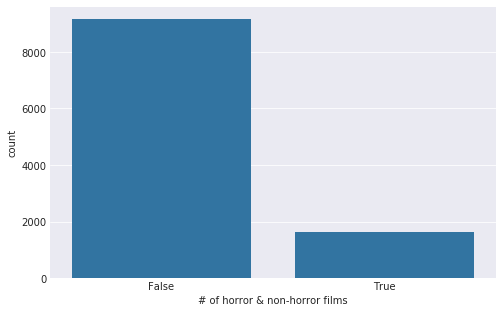

In [20]:
# plot a bar chart
plt.figure(figsize=[8, 5])
default_color = sns.color_palette()[0]
sns.countplot(data = df_clean, x = 'horror', color = default_color)
plt.xlabel('# of horror & non-horror films')

The total number of non-horror films is over 4 times more than the number of horror films.
<br><br>
In bivariate exploration, I will the number of all movies over the years, and then specifically the number of horror films over the years.

Now I'll check popularity variable.

Text(0.5,0,'Popularity')

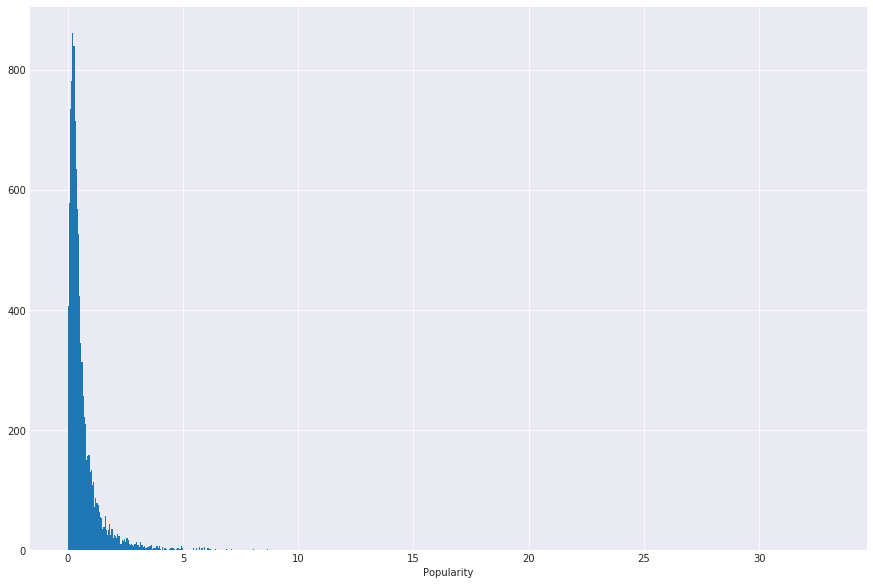

In [21]:
# plot a standard-scaled histogram
binsize = 0.05
bins = np.arange(0, df_clean.popularity.max()+binsize, binsize)

plt.figure(figsize=[15, 10])
plt.hist(data = df_clean, x = 'popularity', bins = bins)
plt.xlabel('Popularity')

This plot shows some immediate points of attention. Most of the data falls on the far left of the axe, meaning strong outliers on the right. I need to identify these outliers. 

In [22]:
# select high outliers by obervation from the plot
high_outliers = (df_clean['popularity'] > 10) 
print(high_outliers.sum())
df_clean.loc[high_outliers,:].sort_values(by='popularity')

11


,id,popularity,original_title,director,keywords,runtime,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj,decades,horror
634,122917,10.174599,The Hobbit: The Battle of the Five Armies,Peter Jackson,corruption|elves|dwarves|orcs|middle-earth (to...,144,"[Adventure, Fantasy]",3110,7.1,2014,2.302728e+08,8.797523e+08,2010s,False
633,131631,10.739009,The Hunger Games: Mockingjay - Part 1,Francis Lawrence,resistance|post-apocalyptic|dystopia|war|sequel,123,"[Science Fiction, Adventure, Thriller]",3590,6.6,2014,1.151364e+08,6.927528e+08,2010s,False
3,140607,11.173104,Star Wars: The Force Awakens,J.J. Abrams,android|spaceship|jedi|space opera|3d,136,"[Action, Adventure, Science Fiction, Fantasy]",5292,7.5,2015,1.839999e+08,1.902723e+09,2010s,False
632,245891,11.422751,John Wick,Chad Stahelski|David Leitch,hitman|revenge|murder|gangster|dog,101,"[Action, Thriller]",2712,7.0,2014,1.842182e+07,7.252661e+07,2010s,False
1329,11,12.037933,Star Wars,George Lucas,android|galaxy|hermit|death star|lightsaber,121,"[Adventure, Action, Science Fiction]",4428,7.9,1977,3.957559e+07,2.789712e+09,1970s,False
631,100402,12.971027,Captain America: The Winter Soldier,Joe Russo|Anthony Russo,washington d.c.|future|shield|marvel comic|comic,136,"[Action, Adventure, Science Fiction]",3848,7.6,2014,1.565855e+08,6.583651e+08,2010s,False
2,262500,13.112507,Insurgent,Robert Schwentke,based on novel|revolution|dystopia|sequel|dyst...,119,"[Adventure, Science Fiction, Thriller]",2480,6.3,2015,1.012000e+08,2.716190e+08,2010s,False
630,118340,14.311205,Guardians of the Galaxy,James Gunn,marvel comic|spaceship|space|scene during end ...,121,"[Action, Science Fiction, Adventure]",5612,7.9,2014,1.565855e+08,7.122911e+08,2010s,False
629,157336,24.949134,Interstellar,Christopher Nolan,saving the world|artificial intelligence|fathe...,169,"[Adventure, Drama, Science Fiction]",6498,8.0,2014,1.519800e+08,5.726906e+08,2010s,False
1,76341,28.419936,Mad Max: Fury Road,George Miller,future|chase|post-apocalyptic|dystopia|australia,120,"[Action, Adventure, Science Fiction, Thriller]",6185,7.1,2015,1.379999e+08,3.481613e+08,2010s,False


There are 11 high outliers away from the major block of distribution, with the top 3 being 24.949134, 28.419936, 32.985763. They are valid data, just with high popularity. 

(0, 10)

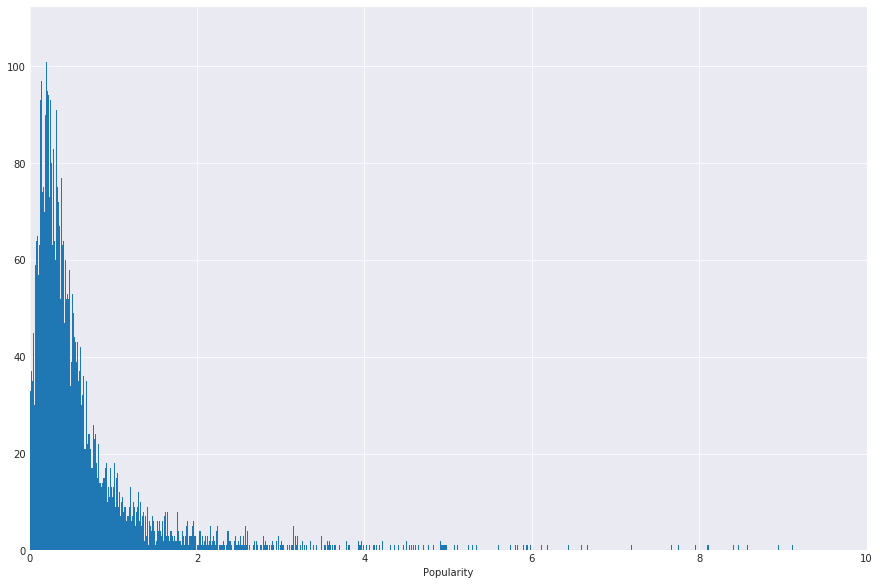

In [23]:
# set the ceiling for popularity and replot a distribution
binsize = 0.005
bins = np.arange(0, df_clean.popularity.max()+binsize, binsize)

plt.figure(figsize=[15, 10])
plt.hist(data = df_clean, x = 'popularity', bins = bins)
plt.xlabel('Popularity')
plt.xlim([0, 10])

Popularity has a long-tailed distribution. A large amount of films falls on the low popularity end, with popularity of less than 1 point to be exact. <br>
The gap in popularity is huge. Huge amounts of movies with popularity of less than 1 while blockbusters like 'Guardians of the Galaxy' and 'Jurassic World' get rocket-high popularity of more than 25.<br><br>
I plan on exploring popularity of horror and non-horror films in bivariate exploration and see if there's a wide spread exists in the particular horror genre.

Next I'll look at variable vote_average.

Text(0.5,0,'Average Rating')

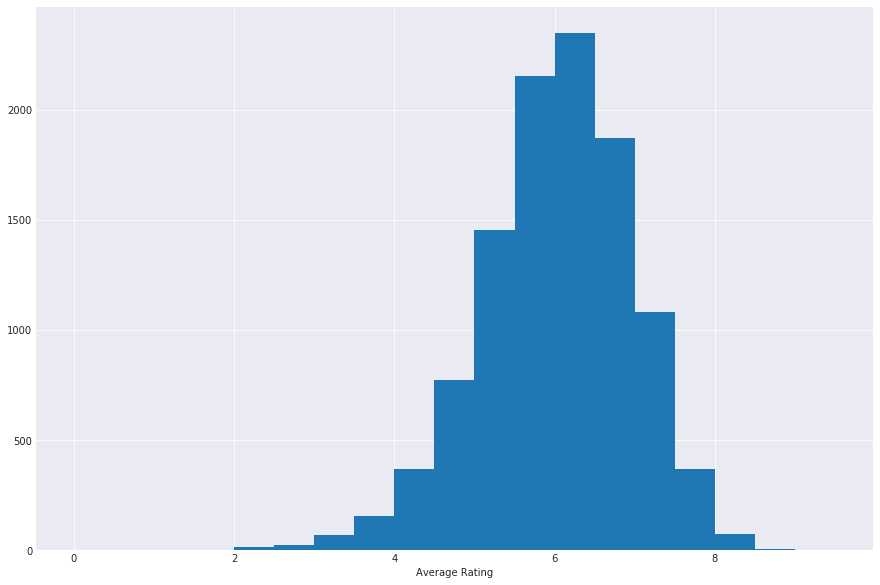

In [24]:
# plot a standard-scaled histogram
binsize = 0.5
bins = np.arange(0, df_clean.vote_average.max()+binsize, binsize)

plt.figure(figsize=[15, 10])
plt.hist(data = df_clean, x = 'vote_average', bins = bins)
plt.xlabel('Average Rating')

Text(0.5,0,'Average Vote')

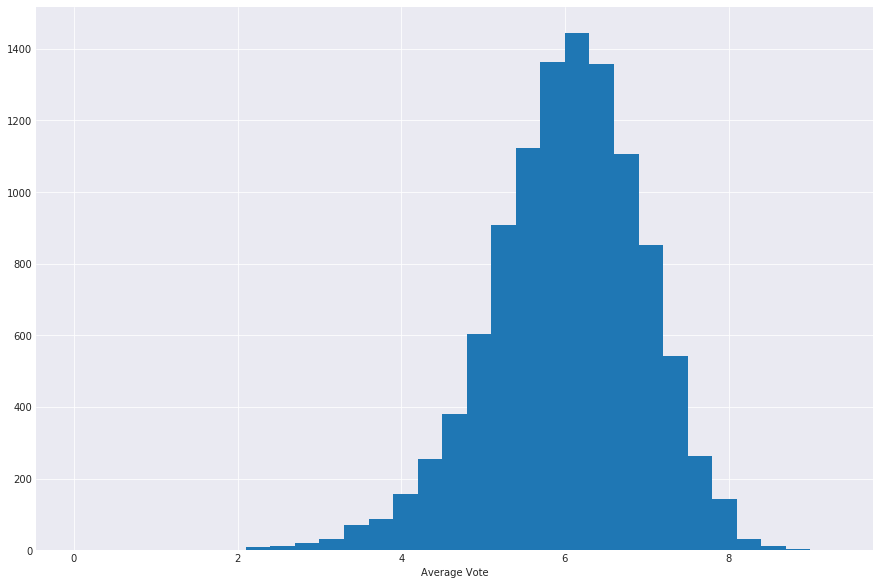

In [25]:
# further investigate on a smaller bin size
binsize = 0.3
bins = np.arange(0, df_clean.vote_average.max()+binsize, binsize)

plt.figure(figsize=[15, 10])
plt.hist(data = df_clean, x = 'vote_average', bins = bins)
plt.xlabel('Average Vote')

vote_average is unimodal, although the distribution is slightly left skewed. Big part of the data falls between 5 to 7. 
<br><br>
In bivarate exploration, I plan on finding out the vote_average of horror and non-horror films.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

The horror variable shows that the total number of non-horror films is over 4 times more than the number of horror films.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

When exploring popularity variable, a few strong outliers were observed. These points are valid with very high popularity value. To further investigate the distribution, I filter out the outliers. The popularity shows a long-tailed distribution, with a large amount of films falls on the low popularity end. 


<a id='bi'></a>
## Bivariate Exploration

First, I'll look at the number of films released over the years.

In [26]:
# group by release_year and get the count of movies for each year
yrs_movies = df_clean.groupby('release_year').count()['id']
movies_by_years = yrs_movies.values
# get all the release_year values
years = yrs_movies.index

Text(0,0.5,'Number of Movies')

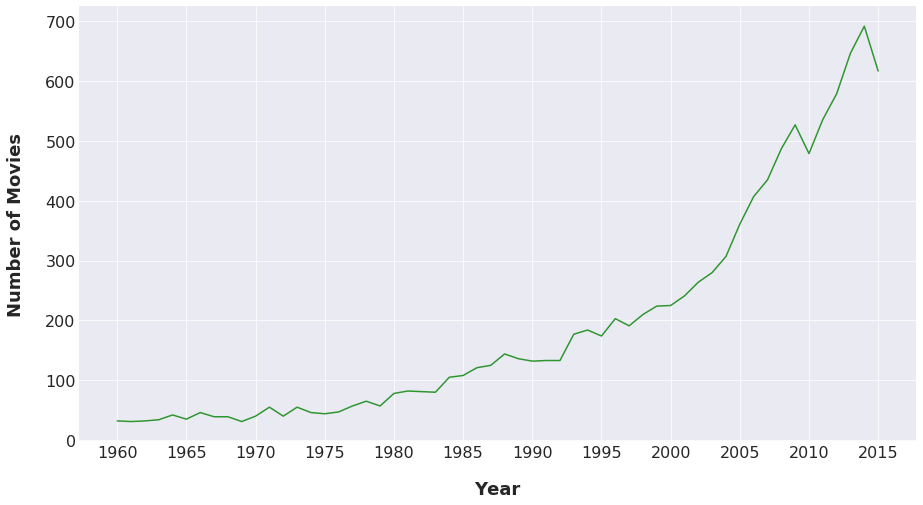

In [27]:
# plot a line chart
plt.figure(figsize=(15,8))
plt.plot(years, movies_by_years, color = 'g', alpha = 0.8)

# customize ticks, labels, and title    
plt.xticks(np.arange(1960, 2015+5, 5), np.arange(1960, 2015+5, 5), fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('Year', fontweight = 'bold', fontsize = 18, labelpad = 20)
plt.ylabel('Number of Movies', fontweight = 'bold', fontsize = 18, labelpad = 20)

The number of movies released has an overall trend of increase from 1960 to 2015. Also, the number of movies released started to rocket up in 1995, and has been staying strong consistently since then. 

Moreover, I'd like to explore how fast the growth in number is, by setting three milestones 200, 400, 600, and checking how many years for the number of movies to reach these 3 milestones.

In [28]:
# get the years that first reach the threshold of 200, 400, 600 movies respectively
# and get the number of movies corresponding to these years
milestones = [200, 400, 600]
yrs_milestones = []
mvs_milestones = []
for x in milestones:
    yrs_milestones.append(yrs_movies[movies_by_years>x].index[0])
    mvs_milestones.append(yrs_movies[movies_by_years>x].values[0])

Text(0,0.5,'Number of Movies')

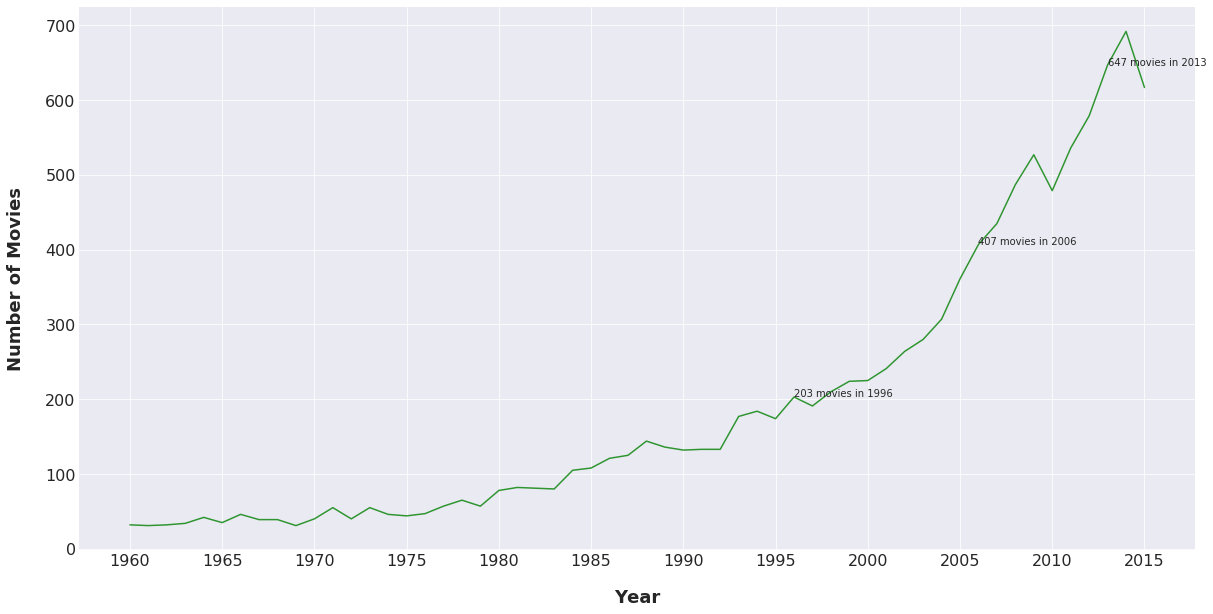

In [29]:
# replot with annotations
# plot the line chart
plt.figure(figsize=(20,10))
plt.plot(years, movies_by_years, color = 'g', alpha = 0.8)

# add labels of points of interest
for x,y in zip(yrs_milestones, mvs_milestones):
    label = "{} movies in {}".format(y, x)
    plt.annotate(label, (x,y)) 

plt.xticks(np.arange(1960, 2015+5, 5), np.arange(1960, 2015+5, 5), fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('Year', fontweight = 'bold', fontsize = 18, labelpad = 20)
plt.ylabel('Number of Movies', fontweight = 'bold', fontsize = 18, labelpad = 20)

It took the movie industry 36 years to reach 200 movies released record; 10 years to reach 400 movies threshold; 7 years to reach 600. Very impressive.

Now I'd like to focus on the growth in number of horror films over the years.

In [30]:
# filter only horror films
df_horror = df_clean.query('horror == True')
# group by release_year and get the count of movies for each year
yrs_horror = df_horror.groupby('release_year').count()['id']
horror_by_years = yrs_horror.values
# get all the release_year values
years = yrs_horror.index

Text(0,0.5,'Number of Horror Movies')

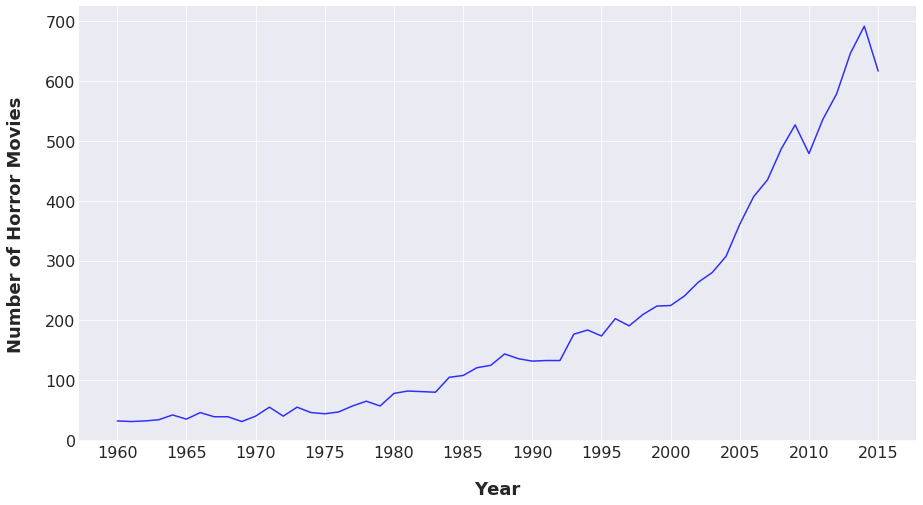

In [31]:
# plot a line chart
plt.figure(figsize=(15,8))
plt.plot(years, movies_by_years, color = 'b', alpha = 0.8)

# customize ticks, labels, and title    
plt.xticks(np.arange(1960, 2015+5, 5), np.arange(1960, 2015+5, 5), fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('Year', fontweight = 'bold', fontsize = 18, labelpad = 20)
plt.ylabel('Number of Horror Movies', fontweight = 'bold', fontsize = 18, labelpad = 20)

Horror films showed similar pattern as oberved in the plot of all films. The number of horror movies released has an overall trend of increase from 1960 to 2015, although the trend is less smooth with rugged fluctuation. Since the year 2004, the number of horror movies started to substantially increase, which is in-part observed in the trend of all films.<br><br>
It makes sense that when the total number of films increase, a great chance lies in a consistent increase in a certain genre of films. To understand more about how the number of horror films grows since 2004, besides looking at the absolute number, I also want to check the relative frequency. 

Now I move on to focus on horror films from 2004 to 2015. This time I'll explore horror films in percentage of all films. 

In [32]:
# create a dataframe includes only release_year in and after 2004
df_horror_2 = df_horror.query('release_year >= 2004')

In [33]:
# get the total of horror films per year since 2004
counts_horror = df_horror_2.groupby('release_year').count()['id']
# get the total of films per year since 1990
totals = df_clean.query('release_year >= 1990').groupby('release_year').count()['id']
# compute the proportion of horror films in films released per year
horror_proportion = counts_horror/totals

In [34]:
# get the release_year data for x-axis
release_years = horror_proportion.index
# get the proportion values for y-axis
proportions = horror_proportion.values

Text(0.5,0,'Year')

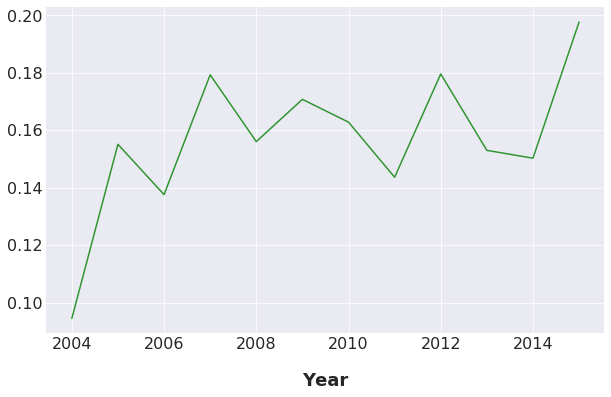

In [35]:
# plot a line chart
plt.figure(figsize=(10,6))
plt.plot(release_years, proportions, color = 'g', alpha = 0.8)

# customize ticks, labels, and title  
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('Year', fontweight = 'bold', fontsize = 18, labelpad = 20)

Horror genre has an overall upward trend in its percentage among all films. It started from less than 10% back in 2004 to almost 20% in 2015. Considering how fast the whole movie industry was growing during that same period, it's even more impressive to see such increase in percentage. It shows horror film had been achieving a bigger share of the pie in movie industry and movie-makers were motivated to make more horror films for the market.

With exploration of how popular horror films had been over the years in the movie market, next I'll switch gear and check the vote_average and popularity of horror films.

For vote_average and popularity, I'll compare horror films with non-horror films.

I'll use both violin plots and box plots for vote_average and horror variables.

(0.64077608019693955, 9.905591517924087)

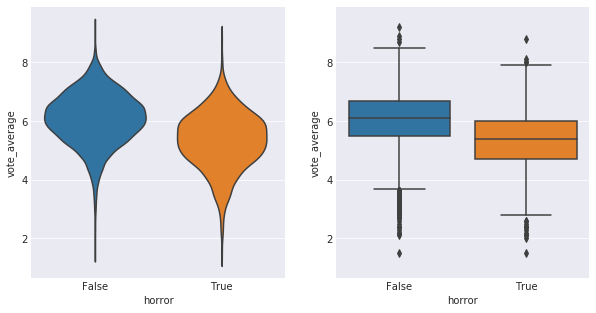

In [36]:
plt.figure(figsize = [10, 5])
    
# left plot: violin plot
plt.subplot(1, 2, 1)
ax1 = sns.violinplot(data = df_clean, x = 'horror', y = 'vote_average', inner = None)
    
# right plot: box plot
plt.subplot(1, 2, 2)
ax2  = sns.boxplot(data = df_clean, x = 'horror', y = 'vote_average')

# set y-axis limits to be same as left plot
plt.ylim(ax1.get_ylim()) 

In the violin plots, it appears that non-horror films and horror films show similar unimodal distribution, and both with a slightly left-skewed, suggesting median larger than mean for both horror and non-horror films. 
<br><br>
In the box plots, non-horror films exceeds horror films in vote_average, with larger minimum, maximum, first quartile, third quartile and median of the distribution.
<br><br>
Thus, in terms of vote_average, horror films are infavorable compared with non-horror.
<br><br>

Now I'll compare horror and non-horror films by popularity.

With the exploration of popularity in the first section, I already know that there're some strong outliers with high popularity. But before taking them off, I decide to first use violin plots to see the distributions in both horror and non-horror.

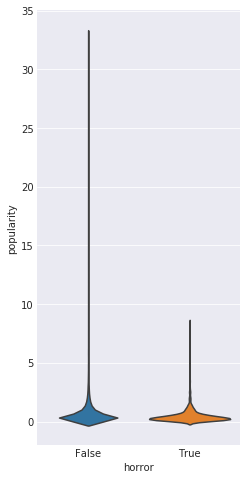

In [37]:
plt.figure(figsize = [8, 8])   
# violin plot
plt.subplot(1, 2, 1)
ax1 = sns.violinplot(data = df_clean, x = 'horror', y = 'popularity', inner = None)

There're two interesting obervations. Non-horror films has a much longer right tail that horor films, suggesting most of the huge outliers are non-horror films. Also, horror films appears to have a much slimmer unimodal distribution.

I'll reuse the codes and perform both violin plots and box plots for popularity and horror variables. This time, I'll set the ceiling for popularity based on visual assessment.

(-0.56250595092643396, 6.5476889509264335)

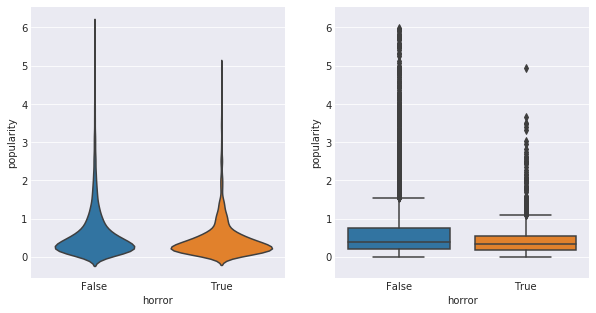

In [38]:
df_ceiling = df_clean.query('popularity <= 6')
plt.figure(figsize = [10, 5])
    
# left plot: violin plot
plt.subplot(1, 2, 1)
ax1 = sns.violinplot(data = df_ceiling, x = 'horror', y = 'popularity', inner = None)
# right plot: box plot
plt.subplot(1, 2, 2)
ax2 = sns.boxplot(data = df_ceiling, x = 'horror', y = 'popularity')

# set y-axis limits to be same as left plot
plt.ylim(ax1.get_ylim()) 

In the violin plots, it appears that non-horror films and horror films both show unimodal distribution, and both with a long right tail, suggesting strong outliers. 
<br><br>
In the box plots, non-horror films exceeds horror films with larger maximum and third quartile. Both median values falls way behind 1.  

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?
The number of movies has an overall trend of increase from 1960 to 2015, especially after 1995. Under this climate, the horror films shows an upward trend in number from 1960 to 2015, and witnessed substantially increase since 2004. <br><br>
Horror films in its percentage among all films since 2004 shows consistent pattern. But it also tells a more impressive story. The percentage started from less than 10% back in 2004 to almost 20% in 2015. <br><br>
### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?
Non-horror films appears to be more favorable than horror films in terms of average rating. This is much less obvious in popularity. However, horror genre fell short in providing movies with huge success in popularity. All of those rendering massive popularity are non-horror films.


<a id='multi'></a>
## Multivariate Exploration

Next, I'll try to investigate further by adding decades to see how the vote_average and popularity of horror and non-horror films change over decades.

In [41]:
# the median of vote_average for horror and non-horror in each decade 
df_v = df_clean.groupby(['decades', 'horror'], as_index = False)['vote_average'].median()

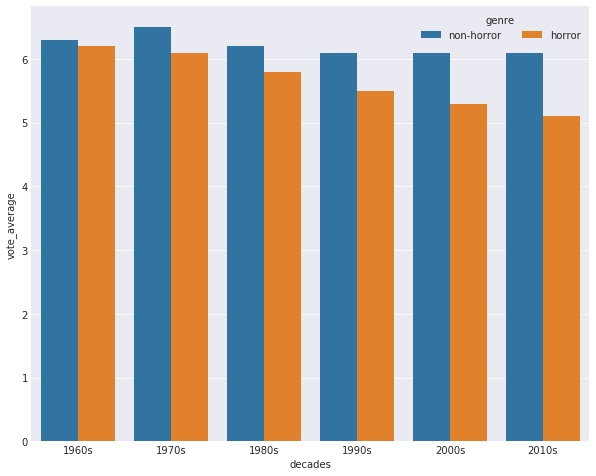

In [42]:
labels = ['non-horror', 'horror']
# plot the bar chart
plt.figure(figsize=(10,8))
ax = sns.barplot(data = df_v, x = 'decades', y = 'vote_average', hue = 'horror')
# set the labels
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, loc = 1, ncol = 2, framealpha = 1, title = 'genre')

In every decade, the median vote_average of non-horror films is always higher than that of horror films. <br><br>The vote_average of non-horror films appears to be quite consistent over the decades. In contrast, the vote_average of horror films kept decreasing decade by decade.

In [43]:
# the median of popularity for horror and non-horror in each decade 
df_p = df_clean.groupby(['decades', 'horror'], as_index = False)['popularity'].median()

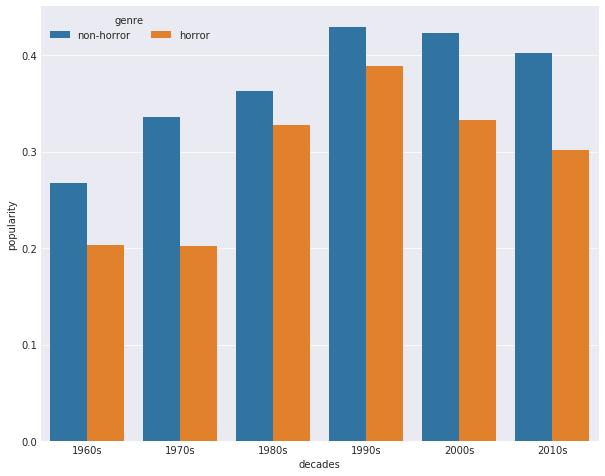

In [44]:
# plot the bar chart
plt.figure(figsize=(10,8))
ax = sns.barplot(data = df_p, x = 'decades', y = 'popularity', hue = 'horror')
# set the labels
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, loc = 2, ncol = 2, framealpha = 1, title = 'genre')

In every decade, non-horror films won horror films in popularity. <br><br>Over the decades, popularity of horror films reached peak in 1990s. 

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?
I investigate further on vote_average and popularity of horror vs. non-horror films in the section by introducing decades categorical variable into the play. In every decade, the vote_average and popularity of non-horror films is always higher than those of horror films. Horror as a genre never stood out among other genres over the decades. It shows itself still a less-favorable genre in the eyes of audience by the rating people voted and popularity it rendered.


### Were there any interesting or surprising interactions between features?
In bivariate exploration section, I oberved that movie-makers made more and more horror films and pushed the increase of the genre's percentage among all films. I am suprised to see that the popularity and vote_average don't follow the trend. Both show constant decrease over the past two decades.

In [45]:
# export the dataframe to a csv file
df_clean.to_csv('tmdb-movies_clean.csv', index = None)